In [1]:
%load_ext autoreload
%autoreload 2
# %load_ext line_profiler

In [2]:
import pathlib
from ase.io import read
from ase.visualize import view
import matplotlib.pyplot as plt
import numpy as np 
import torch 
torch.set_default_dtype(torch.float64)

import rascaline.torch

import metatensor.torch as mts

from metatensor.torch import Labels, TensorBlock, TensorMap
from metatensor.learn import IndexedDataset, DataLoader
from metatensor.learn.data import group as mts_group, group_and_join as group_and_join_mts

from mlelec.data.dataset import QMDataset, split_by_Aij_mts
from mlelec.utils.twocenter_utils import _to_coupled_basis, lowdin_orthogonalize
from mlelec.utils.pbc_utils import matrix_to_blocks, kmatrix_to_blocks, TMap_bloch_sums, precompute_phase, kblocks_to_matrix, kmatrix_to_blocks, blocks_to_matrix, matrix_to_blocks
from mlelec.utils.plot_utils import print_matrix, matrix_norm, block_matrix_norm, plot_block_errors
from mlelec.features.acdc import compute_features
from mlelec.utils.target_utils import get_targets
from mlelec.models.linear import LinearModelPeriodic
# from mlelec.models.linear_integrated import LinearModelPeriodic
from mlelec.metrics import L2_loss, L2_loss_meanzero

/media/nigam/b5749eb7-d3f1-4495-adeb-2c318fb7d0de/MAC/mlelec/src/mlelec/utils/symmetry.py:233: SyntaxWarning: invalid escape sequence '\s'
  """
/media/nigam/b5749eb7-d3f1-4495-adeb-2c318fb7d0de/MAC/mlelec/src/mlelec/utils/symmetry.py:343: SyntaxWarning: invalid escape sequence '\s'
  """
/media/nigam/b5749eb7-d3f1-4495-adeb-2c318fb7d0de/MAC/mlelec/src/mlelec/utils/symmetry.py:389: SyntaxWarning: invalid escape sequence '\s'
  """
/media/nigam/b5749eb7-d3f1-4495-adeb-2c318fb7d0de/MAC/mlelec/src/mlelec/utils/symmetry.py:483: SyntaxWarning: invalid escape sequence '\s'
  """


In [3]:
from mlelec.utils.pbc_utils import move_orbitals_to_keys

In [4]:
device = 'cpu'

orbitals = {
    'sto-3g': {
               6: [[1,0,0],[2,0,0],[2,1,-1], [2,1,0],[2,1,1]], 
              }, 
    
}

In [5]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# Dataset

In [6]:
# workdir = './examples/data/periodic/c2-cp2k-benchmarks'

workdir = f'{pathlib.Path().resolve()}/examples/data/periodic/c2-cp2k-benchmarks'
START = 0 
STOP = 10
SKIP = 1
ORBS = 'sto-3g'
root = f'{workdir}'#/examples/data/periodic/c2/cp2k/sto-3g'
data_dir = root

frames = read(f'{data_dir}/C2_174.extxyz', slice(START, SKIP*STOP, SKIP))
rfock = [np.load(f"{data_dir}/C2_174_881_{i}/realfock_{i}.npy", allow_pickle = True).item() for i in range(START, SKIP*STOP, SKIP)]
rfock0_target = [np.load(f"{data_dir}/baseline/C2_174_881_{i}/realfock_{i}.npy", allow_pickle = True).item() for i in range(START, SKIP*STOP, SKIP)]
rover = [np.load(f"{data_dir}/C2_174_881_{i}/realoverlap_{i}.npy", allow_pickle = True).item() for i in range(START, SKIP*STOP, SKIP)]
# rover0 = [np.load(f"{data_dir}/baseline/C2_174_881_{i}/realoverlap_{i}.npy", allow_pickle = True).item() for i in range(START, STOP)]
kmesh = [8,8,1]

for f in frames:
    f.pbc = [True,True,False]
    f.wrap(center = (0,0,0), eps = 1e-60)
    f.pbc = True

# for K, K0 in zip(rfock, rfock0):
#     for T in K:
#         K[T] = K[T] - K0[T]
rfock_diff_target = []
for K, K0 in zip(rfock, rfock0_target):
    rfock_diff_target.append({})
    for T in K:
        rfock_diff_target[-1][T] = K[T] -K0[T]
        
dataset = QMDataset(frames = frames, 
                               kmesh = kmesh, 
                               dimension = 2,
                               fock_realspace = rfock, 
                               overlap_realspace = rover, 
                               device = device, 
                               orbs = orbitals[ORBS], 
                               orbs_name = 'sto-3g')

In [7]:
cutoff = 20
for ALL_PAIRS in [False,True]:
    for SORT_ORBS in [False, True]:
        try:
            blocks = matrix_to_blocks(dataset, cutoff = cutoff, all_pairs = ALL_PAIRS, sort_orbs=SORT_ORBS)
            rht = blocks_to_matrix(blocks, dataset, all_pairs=ALL_PAIRS, sort_orbs=SORT_ORBS)        
            for ifr in range(len(dataset.fock_realspace)):
                for T in dataset.fock_realspace[ifr]:
                    # print(np.linalg.norm(kfock[ifr][ik] -kfock[ifr][ik].conj().T))
                    # print(np.linalg.norm(kfock[ifr][ik]-rhk[ifr][ik].numpy()))
                    assert (np.linalg.norm(dataset.fock_realspace[ifr][T]-rht[ifr][T].numpy()))<1e-10, (ALL_PAIRS, SORT_ORBS,np.linalg.norm(dataset.fock_realspace[ifr][T]-rht[ifr][T].numpy()))
            print(ALL_PAIRS, SORT_ORBS, 'passed')
        except Exception as e:
            print(e)
            print(ALL_PAIRS, SORT_ORBS, 'failed - moving on')
            continue

/media/nigam/b5749eb7-d3f1-4495-adeb-2c318fb7d0de/MAC/mlelec/src/mlelec/utils/pbc_utils.py:1582: SyntaxWarning: invalid escape sequence '\d'
  assert np.isclose(torch.norm(matrixT - matrixmT.T).item(), 0.0), f"Failed to check H({T}) = H({mT})^\dagger"


KeyboardInterrupt: 

In [8]:
for ALL_PAIRS in [True, False]:
    for SORT_ORBS in [True, False]:
        try:
            kblocks = kmatrix_to_blocks(dataset, cutoff = cutoff, all_pairs = ALL_PAIRS, sort_orbs=SORT_ORBS)
            rhk = kblocks_to_matrix(kblocks, dataset, all_pairs=ALL_PAIRS, sort_orbs=SORT_ORBS)        
            for ifr in range(len(dataset.fock_kspace)):
                for ik in range(len(dataset.fock_kspace[ifr])):
                    # print(np.linalg.norm(kfock[ifr][ik] -kfock[ifr][ik].conj().T))
                    # print(np.linalg.norm(kfock[ifr][ik]-rhk[ifr][ik].numpy()))
                    assert (np.linalg.norm(dataset.fock_kspace[ifr][ik]-rhk[ifr][ik].numpy()))<1e-13, (ALL_PAIRS, SORT_ORBS,np.linalg.norm(dataset.fock_kspace[ifr][ik]-rhk[ifr][ik].numpy()))
            print(ALL_PAIRS, SORT_ORBS, 'passed')
        except Exception as e:
            print(e)
            print(ALL_PAIRS, SORT_ORBS, 'failed - moving on')
            continue

True True passed
True False passed
False True passed
False False passed


In [9]:
# blocks = matrix_to_blocks(dataset, cutoff = cutoff, all_pairs = False, sort_orbs=True)
kblocks = kmatrix_to_blocks(dataset, cutoff = cutoff, all_pairs = False, sort_orbs=True)
rhk = kblocks_to_matrix(kblocks, dataset, all_pairs=False, sort_orbs=True)        

## Testset

In [14]:
# workdir = './'
workdir = './examples/data/periodic/c2-cp2k-benchmarks'
START = 120
STOP = 125
SKIP = 1
ORBS = 'sto-3g'
root = f'{workdir}'#/examples/data/periodic/c2/cp2k/sto-3g'
data_dir = root
frames = read(f'{data_dir}/C2_174.extxyz', slice(START, SKIP*STOP, SKIP))
rfock = [np.load(f"{data_dir}/C2_174_881_{i}/realfock_{i}.npy", allow_pickle = True).item() for i in range(START, SKIP*STOP, SKIP)]
rfock0_test = [np.load(f"{data_dir}/baseline/C2_174_881_{i}/realfock_{i}.npy", allow_pickle = True).item() for i in range(START, SKIP*STOP, SKIP)]
rover = [np.load(f"{data_dir}/C2_174_881_{i}/realoverlap_{i}.npy", allow_pickle = True).item() for i in range(START, SKIP*STOP, SKIP)]
# rover0 = [np.load(f"{data_dir}/baseline/C2_174_881_{i}/realoverlap_{i}.npy", allow_pickle = True).item() for i in range(START, STOP)]
kmesh = [8,8,1]

for f in frames:
    f.pbc = [True,True,False]
    f.wrap(center = (0,0,0), eps = 1e-60)
    f.pbc = True

# for K, K0 in zip(rfock, rfock0):
#     for T in K:
#         K[T] = K[T] - K0[T]
rfock_diff_test= []
for K, K0 in zip(rfock, rfock0_test):
    rfock_diff_test.append({})
    for T in K:
        rfock_diff_test[-1][T] = K[T] -K0[T]
        

testset = QMDataset(frames = frames, 
                               kmesh = kmesh, 
                               dimension = 2,
                               fock_realspace = rfock, 
                               overlap_realspace = rover, 
                               device = device, 
                               orbs = orbitals[ORBS], 
                               orbs_name = 'sto-3g')

## Compute target

In [8]:
cutoff = 8
SORT_ORBS = True
target_blocks, target_coupled_blocks = get_targets(dataset, cutoff = cutoff, device = device, all_pairs = False, sort_orbs=SORT_ORBS)
_, overlap_coupled_blocks = get_targets(dataset, cutoff = cutoff, device = device, target = 'overlap')
target_blocks_base, target_coupled_blocks_base = get_targets(dataset, cutoff = cutoff, device = device, all_pairs = False, sort_orbs=SORT_ORBS, matrix=rfock_diff_target)
_, target_coupled_blocks_fock0 = get_targets(dataset, cutoff = cutoff, device = device, all_pairs = False, sort_orbs=SORT_ORBS, matrix=rfock0_target)
# target_kspace_base = dataset.bloch_sum(blocks_to_matrix(target_coupled_blocks_base, dataset))
# overlap_kspace = dataset.bloch_sum(blocks_to_matrix(overlap_coupled_blocks, dataset))

In [9]:
target_coupled_blocks_copy = target_coupled_blocks

In [15]:
_, test_coupled_blocks = get_targets(testset, cutoff = cutoff, device = device, all_pairs = False, sort_orbs=SORT_ORBS)
_, overlap_coupled_blocks_test = get_targets(dataset, cutoff = cutoff, device = device, target = 'overlap')
test_blocks_base, test_coupled_blocks_base = get_targets(testset, cutoff = cutoff, device = device, all_pairs = False, sort_orbs=SORT_ORBS, matrix=rfock_diff_test)
_, test_coupled_blocks_fock0 = get_targets(testset, cutoff = cutoff, device = device, all_pairs = False, sort_orbs=SORT_ORBS, matrix=rfock0_test )
# test_kspace = testset.bloch_sum(blocks_to_matrix(test_coupled_blocks, testset))
# test_kspace_base = testset.bloch_sum(blocks_to_matrix(test_coupled_blocks_base, testset))
# overlap_kspace_test = dataset.bloch_sum(blocks_to_matrix(overlap_coupled_blocks_test, testset))

In [10]:
target_kspace = dataset.bloch_sum(blocks_to_matrix(target_coupled_blocks, dataset))

In [16]:
test_kspace = dataset.bloch_sum(blocks_to_matrix(test_coupled_blocks, testset))

# Features 

In [17]:
max_radial  = 6
max_angular = 4
atomic_gaussian_width = 0.3
spline_basis = False

hypers_pair = {'cutoff': cutoff,
               'max_radial': max_radial,
               'max_angular': max_angular,
               'atomic_gaussian_width': atomic_gaussian_width,
               'center_atom_weight': 1,
               "radial_basis": {"Gto": {}},
               "cutoff_function": {"ShiftedCosine": {"width": 0.1}}}


hypers_atom = {'cutoff': 4,
               'max_radial': max_radial,
               'max_angular': max_angular,
               'atomic_gaussian_width': atomic_gaussian_width,
               'center_atom_weight': 1,
               "radial_basis": {"Gto": {}},
               "cutoff_function": {"ShiftedCosine": {"width": 0.1}}}


return_rho0ij = False
both_centers = False
LCUT = 3

hfeat = compute_features(dataset, hypers_atom, hypers_pair=hypers_pair, lcut = LCUT, all_pairs=False)

cpu pair features
cpu single center features
cpu single center features


In [18]:
hfeat_test = compute_features(testset, hypers_atom, hypers_pair=hypers_pair, lcut = LCUT, all_pairs=False)

cpu pair features
cpu single center features
cpu single center features


# Model

## RIDGE models 

In [13]:
def train_ridge(model, target_blocks, set_bias=False, alphas = None, kernel_ridge = False, alpha = None):
    block_losses = {}
    loss = 0
    pred, ridges = model.fit_ridge_analytical(return_matrix = False, set_bias = set_bias, kernel_ridge = kernel_ridge, alphas = alphas, alpha = alpha)

    for (key, block) in pred.items():
        block_loss=torch.norm(block.values - target_blocks[key].values)**2
        loss += block_loss
        
        block_losses[tuple(key.values)] = block_loss

    # print(np.sum(list(block_losses.values())))
    return loss, pred, ridges, block_losses#, kernels 

### A - direct H(T)

In [14]:
model_ridge = LinearModelPeriodic(twocfeat = hfeat, 
                                  target_blocks = target_coupled_blocks,
                                  frames = dataset.structures, orbitals = dataset.basis, 
                                  device = device)

model_ridge = model_ridge.double()
loss_ridge_bias, pred_ridge_bias, ridges_bias, loss_blocks = train_ridge(model_ridge, 
                                                                         target_coupled_blocks,
                                                                         set_bias = True,
                                                                         kernel_ridge = False,
                                                                         # alphas = np.logspace(-10, -2, 100),
                                                                         alphas = np.logspace(-10, 1, 100),
                                                                         # alpha = 1e-4
                                                                        )
print(loss_ridge_bias)

tensor(3.1771e-06)


In [15]:
pred_test_ridge = model_ridge.predict_ridge_analytical(ridges_bias, hfeat_test)
L2_loss(test_coupled_blocks, pred_test_ridge)

/media/nigam/b5749eb7-d3f1-4495-adeb-2c318fb7d0de/MAC/mlelec/src/mlelec/models/linear.py:782: UserWarning: Using train target_blocks, otherwise provide test target_blocks
  warnings.warn('Using train target_blocks, otherwise provide test target_blocks')


tensor(0.0033)

### B. - baselined H(T)

In [16]:
model_ridge = LinearModelPeriodic(twocfeat = hfeat, 
                                  target_blocks = target_coupled_blocks_base,
                                  frames = dataset.structures, orbitals = dataset.basis, 
                                  device = device)

model_ridge = model_ridge.double()
loss_ridge_bias, pred_ridge_bias, ridges_bias, loss_blocks = train_ridge(model_ridge, 
                                                                         target_coupled_blocks_base,
                                                                         set_bias = True,
                                                                         kernel_ridge = False,
                                                                         # alphas = np.logspace(-10, -2, 100),
                                                                         alphas = np.logspace(-10, 1, 100),
                                                                         # alpha = 1e-4
                                                                        )
print(loss_ridge_bias)
pred_ht = mts.add(pred_ridge_bias, target_coupled_blocks_fock0)
L2_loss(pred_ht, target_coupled_blocks)

tensor(5.2701e-09)


tensor(5.2701e-09)

In [17]:
pred_test_ridge = model_ridge.predict_ridge_analytical(ridges_bias, hfeat_test)
# pred_ht = mts.add(pred_test_ridge, test_coupled_blocks_fock0)
# L2_loss(test_coupled_blocks, pred_ht)

/media/nigam/b5749eb7-d3f1-4495-adeb-2c318fb7d0de/MAC/mlelec/src/mlelec/models/linear.py:782: UserWarning: Using train target_blocks, otherwise provide test target_blocks
  warnings.warn('Using train target_blocks, otherwise provide test target_blocks')


### D. -  H(k)

In [48]:
from mlelec.utils.pbc_utils import precompute_phase, TMap_bloch_sums, TMap_bloch_sums_feat
phase, indices ,_= precompute_phase(hfeat, dataset)
hfeat_kspace = TMap_bloch_sums_feat(hfeat, phase, indices, _, return_tensormap=True)

In [49]:
# (target_coupled_blocks[4].values[0]*np.sqrt(2)+torch.sum(target_coupled_blocks[11].values[:38], axis=0))
# ((hfeat[0].values[0]*np.sqrt(2)+torch.sum(hfeat[7].values[:38], axis=0)) - hfeat_kspace[0].values[0]).norm()

In [50]:
phase, indices ,_= precompute_phase(target_coupled_blocks, dataset)
target_coupled_blocks_k = TMap_bloch_sums(target_coupled_blocks, phase, indices, _, return_tensormap=True)

In [51]:
kblocks = _to_coupled_basis(kmatrix_to_blocks(dataset, cutoff=cutoff),skip_symmetry = False, device = device, translations = False)

In [88]:
for (k1, b1)in target_coupled_blocks_k.items():
    b2 = kblocks.block(k1)
    b2 = mts.sort_block(b2)
    # b2 = _match_feature_and_target_samples(b1, b2, return_idx=True)
    _,m1,m2 = b1.samples.intersection_and_mapping(b2.samples)
    b2val = b2.values[m2]
    assert torch.all(b1.samples.values[m1] == b2.samples.values[m2]), (b1.samples.values[m1], b2.samples.values[m2])
    # print(k1.values, b1.values.shape,b2.values.shape)
    print(k1.values, (b1.values-b2val).norm())

tensor([-1,  6,  1,  0,  6,  2,  0,  0], dtype=torch.int32) tensor(2.3452e-15)
tensor([-1,  6,  1,  0,  6,  2,  1,  1], dtype=torch.int32) tensor(8.6941e-15)
tensor([-1,  6,  2,  0,  6,  2,  1,  1], dtype=torch.int32) tensor(3.5022e-09)
tensor([-1,  6,  2,  1,  6,  2,  1,  1], dtype=torch.int32) tensor(7.3161e-14)
tensor([1, 6, 1, 0, 6, 1, 0, 0], dtype=torch.int32) tensor(8.5487e-14)
tensor([1, 6, 1, 0, 6, 2, 0, 0], dtype=torch.int32) tensor(2.3656e-14)
tensor([1, 6, 1, 0, 6, 2, 1, 1], dtype=torch.int32) tensor(3.7698e-15)
tensor([1, 6, 2, 0, 6, 2, 0, 0], dtype=torch.int32) tensor(1.6346e-09)
tensor([1, 6, 2, 0, 6, 2, 1, 1], dtype=torch.int32) tensor(2.5883e-11)
tensor([1, 6, 2, 1, 6, 2, 1, 0], dtype=torch.int32) tensor(1.3456e-08)
tensor([1, 6, 2, 1, 6, 2, 1, 2], dtype=torch.int32) tensor(2.0125e-08)


In [89]:
kblocks = mts.sort(kblocks)

In [54]:
model_ridge = LinearModelPeriodic(twocfeat = hfeat_kspace, 
                                  target_blocks = target_coupled_blocks_k,
                                  frames = dataset.structures, orbitals = dataset.basis, 
                                  device = device)

model_ridge = model_ridge.double()
loss_ridge_bias, pred_ridge_bias, ridges_bias, loss_blocks = train_ridge(model_ridge, 
                                                                         target_coupled_blocks_k,
                                                                         set_bias = True,
                                                                         kernel_ridge = False,
                                                                         alphas = np.logspace(-7, 2, 100),
                                                                        #  alphas = np.logspace(-6, 4, 100),
                                                                        #  alpha = 1e-4
                                                                        )
print(loss_ridge_bias)

tensor(0.0004)


(1e-10, 0.0005232541480597252)

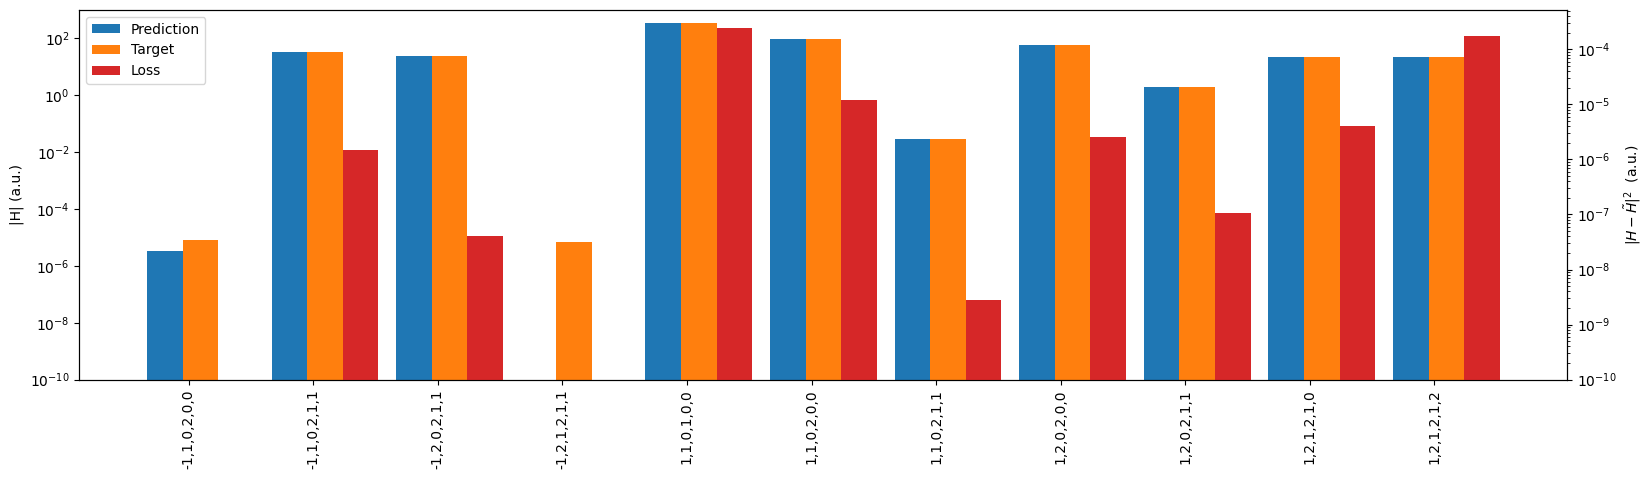

In [22]:
fig, ax, ax2 = plot_block_errors(target_coupled_blocks_k, pred_ridge_bias, plot_loss=True)
ax.set_ylim(1e-10,)
ax2.set_ylim(1e-10,)

In [92]:
model_ridge = LinearModelPeriodic(twocfeat = hfeat_kspace, 
                                  target_blocks = kblocks,
                                  frames = dataset.structures, orbitals = dataset.basis, 
                                  device = device)

model_ridge = model_ridge.double()
loss_ridge_bias, pred_ridge_bias, ridges_bias, loss_blocks = train_ridge(model_ridge, 
                                                                         kblocks,
                                                                         set_bias = True,
                                                                         kernel_ridge = False,
                                                                         alphas = np.logspace(-7, 2, 100),
                                                                        #  alphas = np.logspace(-6, 4, 100),
                                                                        #  alpha = 1e-4
                                                                        )
print(loss_ridge_bias)

tensor(0.0004)


### E. - baselined H(k)

In [22]:
phase, indices ,_= precompute_phase(target_coupled_blocks_base, dataset)
target_coupled_blocks_base_k = TMap_bloch_sums(target_coupled_blocks_base, phase, indices, _, return_tensormap=True)

In [23]:
model_ridge = LinearModelPeriodic(twocfeat = hfeat_kspace, 
                                  target_blocks = target_coupled_blocks_base_k,
                                  frames = dataset.structures, orbitals = dataset.basis, 
                                  device = device)

model_ridge = model_ridge.double()
loss_ridge_bias, pred_ridge_bias, ridges_bias, loss_blocks = train_ridge(model_ridge, 
                                                                         target_coupled_blocks_base_k,
                                                                         set_bias = True,
                                                                         kernel_ridge = False,
                                                                         alphas = np.logspace(-7, 2, 100),
                                                                        #  alphas = np.logspace(-6, 4, 100),
                                                                        #  alpha = 1e-4
                                                                        )
print(loss_ridge_bias)

tensor(7.4700e-07)


### G. - orthogonalize H(k) 

In [105]:
ortho_target_kspace =[]# torch.stack([lowdin_orthogonalize(h, s) for h, s in zip(ttarget_kspace, overlap_kspace)])
for ifr in range(len(target_kspace)):
    ot = torch.stack([lowdin_orthogonalize(h, s) for h, s in zip(target_kspace[ifr], overlap_kspace[ifr])])
    ortho_target_kspace.append(ot)

In [106]:
e_ortho=[]
for ifr in range(len(ortho_target_kspace)):
   eifr=[]
   for k in range(len(ortho_target_kspace[ifr])):
      eifr.append(torch.linalg.eigvalsh(ortho_target_kspace[ifr][k]))
   e_ortho.append(torch.stack(eifr))

In [107]:
import scipy
e_nonorth=[]
for ifr in range(len(target_kspace)):
   eifr=[]
   for k in range(len(target_kspace[ifr])):
      eifr.append(torch.tensor(scipy.linalg.eigvalsh(target_kspace[ifr][k], overlap_kspace[ifr][k])))
   e_nonorth.append(torch.stack(eifr))

In [108]:
for ifr in range(len(dataset)):
    print(ifr, torch.norm(e_ortho[ifr]-e_nonorth[ifr]))

0 tensor(1.3181e-13)
1 tensor(1.3615e-13)
2 tensor(1.4274e-13)
3 tensor(1.1559e-13)
4 tensor(1.1993e-13)


In [62]:
# plt.plot(torch.cat(e_ortho).numpy(), torch.cat(e_nonorth).numpy(), 'o')

In [109]:
oblocks = _to_coupled_basis(kmatrix_to_blocks(dataset, cutoff=cutoff, matrix = ortho_target_kspace),skip_symmetry = False, device = device, translations = False)
oblocks = mts.sort(oblocks)

In [114]:
model_ridge = LinearModelPeriodic(twocfeat = hfeat_kspace, 
                                  target_blocks = oblocks,
                                  frames = dataset.structures, orbitals = dataset.basis, 
                                  device = device)

model_ridge = model_ridge.double()
loss_ridge_bias, pred_ridge_bias, ridges_bias, loss_blocks = train_ridge(model_ridge, 
                                                                         oblocks,
                                                                         set_bias = True,
                                                                         kernel_ridge = False,
                                                                         alphas = np.logspace(-20,4, 100),
                                                                        #  alphas = np.logspace(-6, 4, 100),
                                                                        #  alpha = 1e-4
                                                                        )
print(loss_ridge_bias)

tensor(10058.2337)


(1e-10, 5432.72529376023)

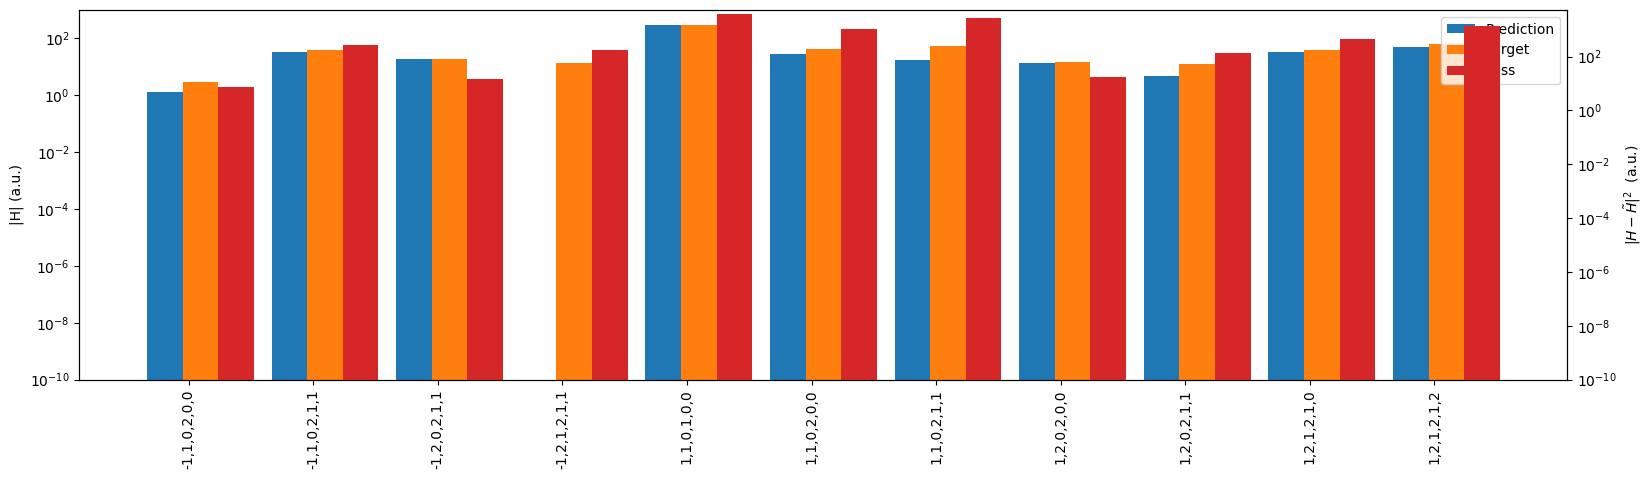

In [115]:
fig, ax, ax2 = plot_block_errors(oblocks, pred_ridge_bias, plot_loss=True)
ax.set_ylim(1e-10,)
ax2.set_ylim(1e-10,)

### H. - orthogonalize baseline

In [100]:
ortho_target_kspace_base =[]# torch.stack([lowdin_orthogonalize(h, s) for h, s in zip(ttarget_kspace, overlap_kspace)])
for ifr in range(len(target_kspace)):
    ot = torch.stack([lowdin_orthogonalize(h, s) for h, s in zip(target_kspace_base[ifr], overlap_kspace[ifr])])
    ortho_target_kspace_base.append(ot)

In [101]:
oblocks_base = _to_coupled_basis(kmatrix_to_blocks(dataset, cutoff=cutoff, matrix = ortho_target_kspace_base),skip_symmetry = False, device = device, translations = False)
oblocks_base = mts.sort(oblocks_base)

In [104]:
model_ridge = LinearModelPeriodic(twocfeat = hfeat_kspace, 
                                  target_blocks = oblocks_base,
                                  frames = dataset.structures, orbitals = dataset.basis, 
                                  device = device)

model_ridge = model_ridge.double()
loss_ridge_bias, pred_ridge_bias, ridges_bias, loss_blocks = train_ridge(model_ridge, 
                                                                         oblocks_base,
                                                                         set_bias = True,
                                                                         kernel_ridge = False,
                                                                         alphas = np.logspace(-7,2, 100),
                                                                        #  alphas = np.logspace(-6, 4, 100),
                                                                        #  alpha = 1e-4
                                                                        )
print(loss_ridge_bias)

tensor(0.6547)


## Torch

In [19]:
from mlelec.utils.pbc_utils import TMap_bloch_sums, precompute_phase
from copy import deepcopy

In [20]:
target_keynames = target_coupled_blocks.keys.names
keys = []
blocks= []
for k,b in target_coupled_blocks.items(): 
    li, lj, L = k['l_i'], k['l_j'], k['L']
    inversion_sigma = (-1) ** (li + lj + L)
    keys.append(torch.cat((k.values, torch.tensor([inversion_sigma]))))
    blocks.append(b.copy())
target_coupled_blocks = TensorMap( Labels(k.names+['inversion_sigma'], torch.stack(keys)), blocks)
                 
target_coupled_blocks_copy = target_coupled_blocks.copy()
target_coupled_blocks = target_coupled_blocks.keys_to_properties(['n_i', 'l_i',  'n_j','l_j'])

In [21]:
target_keynames = test_coupled_blocks.keys.names
keys = []
blocks= []
for k,b in test_coupled_blocks.items(): 
    li,lj, L = k['l_i'], k['l_j'], k['L']
    inversion_sigma = (-1) ** (li + lj + L)
    keys.append(torch.cat((k.values, torch.tensor([inversion_sigma]))))
    blocks.append(b.copy())
test_coupled_blocks = TensorMap( Labels(k.names+['inversion_sigma'], torch.stack(keys)), blocks)
                 
test_coupled_blocks_copy = test_coupled_blocks.copy()
test_coupled_blocks = test_coupled_blocks.keys_to_properties(['n_i', 'l_i',  'n_j','l_j'])

In [22]:
phase, _,_ = precompute_phase(target_coupled_blocks, dataset)
target_k = TMap_bloch_sums(target_coupled_blocks, phase)

test_phase, _,_ = precompute_phase(test_coupled_blocks, testset)
test_k = TMap_bloch_sums(test_coupled_blocks, test_phase)

## New model

In [75]:
from mlelec.models.linear_integrated import LinearModelPeriodic

In [112]:
model = LinearModelPeriodic(twocfeat = hfeat,
                            target_blocks = target_coupled_blocks,
                            frames = dataset.structures, orbitals = dataset.basis, 
                            device = device,
                            bias = True, #True
                            nhidden = 16, 
                            nlayers = 1,
                            activation = 'SiLU',
                            apply_norm = True
                           )

In [113]:
model

LinearModelPeriodic(
  (model): ModuleDict(
    ((-1, 6, 6, 0, 1)): MLP(
      (mlp): Sequential(
        (0): Linear(in_features=180, out_features=16, bias=True)
        (1): EquivariantNonLinearity(
          (nonlinearity): SiLU()
          (nn): Sequential(
            (0): SiLU()
            (1): LayerNorm((16,), eps=1e-05, elementwise_affine=True)
          )
        )
        (2): Linear(in_features=16, out_features=1, bias=True)
      )
    )
    ((-1, 6, 6, 1, 1)): MLP(
      (mlp): Sequential(
        (0): Linear(in_features=288, out_features=16, bias=False)
        (1): EquivariantNonLinearity(
          (nonlinearity): SiLU()
          (nn): Sequential(
            (0): SiLU()
            (1): LayerNorm((16,), eps=1e-05, elementwise_affine=True)
          )
        )
        (2): Linear(in_features=16, out_features=2, bias=False)
      )
    )
    ((-1, 6, 6, 1, -1)): MLP(
      (mlp): Sequential(
        (0): Linear(in_features=144, out_features=16, bias=False)
        (1)

In [114]:
optim = torch.optim.Adam(model.parameters(), lr = 1e-3)
eval_every = 100

In [115]:
losses = []
test_losses = []
BEST = 1e13
for epoch in range(1001):
    
    optim.zero_grad()
    
    pred = model()
    # predk = TMap_bloch_sums(pred, phase)
    
    loss = L2_loss(target_coupled_blocks, pred)
    # loss = L2_loss(target_k, predk)
    
    loss.backward()
    losses.append(loss.item())
    
    optim.step()    

    if epoch%eval_every ==0:
        model.train= False
        test_pred = model.predict(hfeat_test, test_coupled_blocks)
        test_loss = L2_loss(test_pred, test_coupled_blocks)
        test_losses.append(test_loss.item())
        # print(epoch, test_loss.item())
        
        if test_loss<BEST:
            # print('new_best')
            BEST = test_loss
            checkpoint = {'model_statedict':model.state_dict, 
                          'optimizer_statedict':optim.state_dict,
                          'train loss':loss,
                          'test_loss': test_loss,
                          'pred': model()
                         }
            # torch.save(checkpoint, 'checkpoint_2.pt')
        model.train = True
    # if epoch%100 == 0 :
        print(epoch, loss.item(), test_loss.item()) #, L2_loss(target_coupled_blocks, pred).item())
        

0 2314.353142027465 1115.8707182933251
100 11.292062624215566 23.20836231758084
200 0.5996083439256 6.4302981942964
300 0.21872087792438896 5.516882777522887
400 0.12388290265773437 5.113361508765076
500 0.07493049960091618 5.016468171933956
600 0.09138452219456163 4.829563570731197
700 0.032826671823172636 4.070769058571038
800 0.02325757959128011 3.9787593952240856
900 0.018163138174466888 3.596152579775004
1000 0.5610039850208536 3.3762899122252197


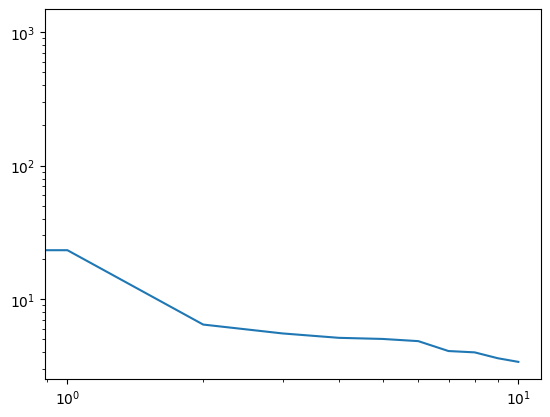

In [116]:
plt.loglog(test_losses)

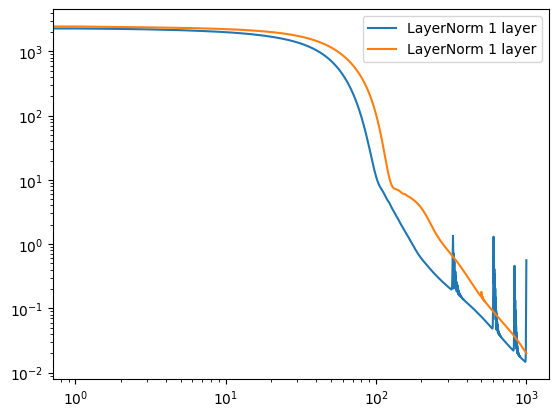

In [117]:
plt.plot(losses, label = 'LayerNorm 1 layer')
# plt.plot(losses_norm_2e3layer, label = 'e3_2')
# plt.plot(losses_norm_e3layer, label = 'e3_1')
plt.plot(losses_norm_1layer, label = 'LayerNorm 1 layer')
# plt.plot(losses_norm_2layer, label = 'LayerNorm 2 layer')
plt.xscale('log')
plt.yscale('log')
plt.legend()

In [74]:
losses_norm_2e3layer = deepcopy(losses)
model_norm_2e3layer = deepcopy(model)

# losses_norm_e3layer = deepcopy(losses)
# model_norm_e3layer = deepcopy(model)

# losses_norm_2layer = deepcopy(losses)
# model_norm_2layer = deepcopy(model)

# losses_norm_1layer = deepcopy(losses)
# model_norm_1layer = deepcopy(model)

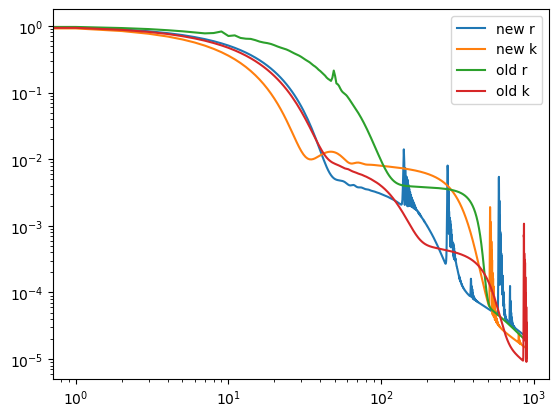

In [129]:
# plt.plot(losses)
x = np.array(losses)[100:]
plt.loglog(x/x[0], label = 'new r')
x = np.array(losses_k)[100:]
plt.loglog(x/x[0], label = 'new k')
x = np.array(usual_losses)[100:]
plt.loglog(x/x[0], label = 'old r')
x = np.array(usual_losses_k)[100:]
plt.loglog(x/x[0], label = 'old k')

plt.legend()

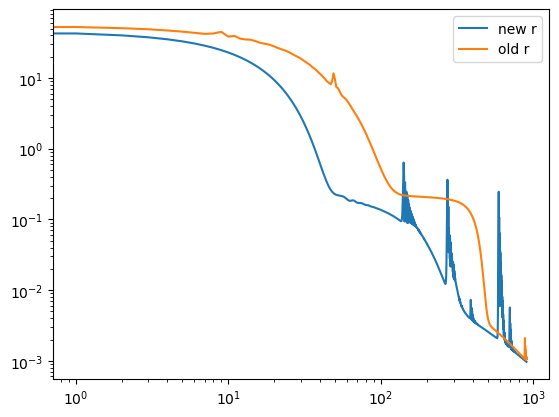

In [131]:
x = np.array(losses)[100:]
plt.loglog(x, label = 'new r')
x = np.array(usual_losses)[100:]
plt.loglog(x, label = 'old r')
plt.legend()

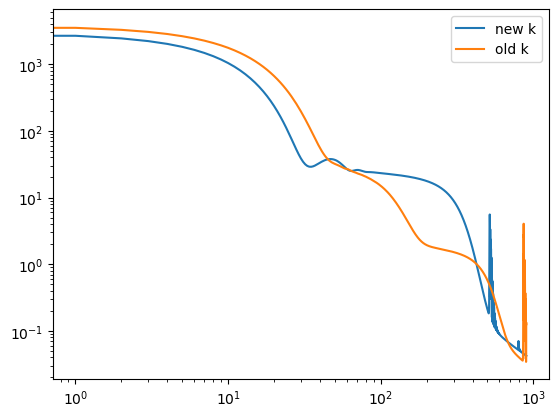

In [130]:
x = np.array(losses_k)[100:]
plt.loglog(x, label = 'new k')
x = np.array(usual_losses_k)[100:]
plt.loglog(x, label = 'old k')
plt.legend()


In [477]:
predintk = move_orbitals_to_keys(predk, target_coupled_blocks_copy[0].properties)
predintk = mts.remove_dimension(predintk, axis='keys', name = 'inversion_sigma')
predintk = mts.permute_dimensions(predintk, axis='keys', dimensions_indexes = [0,1,4,5,2,6,7,3])
predintk = _to_uncoupled_basis(predintk)
newb=[]
for k,b in predintk.items():
    newb.append(
        TensorBlock(
            samples = b.samples,
            components = b.components,
            properties = b.properties,
            values = b.values.detach()
        )
    )
predintk = TensorMap(predintk.keys, newb)
predintk = mts.sort(predintk)

In [478]:
recon_Hk_from_ktarg = kblocks_to_matrix(predintk, dataset, detach = True)

Target matrices with cutoff

In [479]:
cutoff_HT = blocks_to_matrix(target_coupled_blocks_copy_nosigma, dataset, detach=True)
cutoff_Hk = dataset.bloch_sum(cutoff_HT)

MSE on H(T)

In [480]:
tot_mse = 0
for ifr in range(len(recon_HT)):
    for T in recon_HT[ifr]:
        # print(torch.norm(recon_HT[ifr][T] - cutoff_HT[ifr][T]))
        tot_mse += torch.norm(recon_HT[ifr][T] - cutoff_HT[ifr][T])**2
print(tot_mse)

tensor(0.2908)


MSE on H(k) computed from H(T)

In [481]:
tot_mse = 0
for ifr in range(len(recon_Hk)):
    for ik in range(len(recon_Hk[ifr])):
        # print(torch.norm(recon_Hk[ifr][ik] - cutoff_Hk[ifr][ik]))
        tot_mse += torch.norm(recon_Hk[ifr][ik] - cutoff_Hk[ifr][ik])**2
print(tot_mse/64)

tensor(0.2908)


MSE on H(k) computed from kspace blocks

In [482]:
tot_mse = 0
for ifr in range(len(recon_Hk_from_ktarg)):
    for ik in range(len(recon_Hk_from_ktarg[ifr])):
        # print(torch.norm(recon_Hk[ifr][ik] - cutoff_Hk[ifr][ik]))
        tot_mse += torch.norm(recon_Hk_from_ktarg[ifr][ik] - cutoff_Hk[ifr][ik])**2
print(tot_mse/64)

tensor(1.4198)


In [485]:
kblocks = kmatrix_to_blocks(dataset, cutoff = cutoff)
kblocks = mts.sort(kblocks)

In [521]:
phase, _, _ = precompute_phase(target_coupled_blocks_copy_nosigma, dataset)
kblocks = TMap_bloch_sums(target_coupled_blocks_copy_nosigma, phase)
kblocks = mts.sort(kblocks)
kblocks = _to_uncoupled_basis(kblocks)

In [522]:
rHk = kblocks_to_matrix(kblocks, dataset)

In [523]:
for h1, h2 in zip(rHk, cutoff_Hk):
    print(torch.norm(h1-h2))

tensor(7.0550)
tensor(6.4099)


## Usual model

In [84]:
from mlelec.models.linear import LinearModelPeriodic

In [120]:
model_ = LinearModelPeriodic(twocfeat = hfeat,
                                  target_blocks = target_coupled_blocks_copy,
                                  frames = dataset.structures, orbitals = dataset.basis, 
                            device = device,
                            bias = True,
                            nhidden = 9, 
                            nlayers = 1,
                            activation = 'SiLU',
                            apply_norm = True
                           )

In [121]:
count_parameters(model_)

38808

In [122]:
count_parameters(model)

37209

In [123]:
optim = torch.optim.Adam(model_.parameters(), lr = 1e-3)

In [124]:
# usual_losses = []
usual_losses_k = []

In [125]:
phase,_,_=precompute_phase(target_coupled_blocks_copy, dataset)

In [126]:
# losses = []
for epoch in range(1000):
    optim.zero_grad()
    
    pred = model_()
    
    # loss = L2_loss(target_coupled_blocks_copy, pred)
    # usual_losses.append(loss.item())
    
    predk = TMap_bloch_sums(pred, phase)
    loss = L2_loss(predk, target_k_copy)
    usual_losses_k.append(loss.item())
    
    loss.backward()
    optim.step()    
    if epoch%100 == 0 :
        print(epoch, loss.item())
        

0 55306.913052938864
100 3764.0578729135627
200 15.004067927284689
300 1.9339279571662331
400 1.5208913461804758
500 1.12947069667624
600 0.5750015060468137
700 0.167415990013798
800 0.059646992460259694
900 0.040507468730350736


In [198]:
count_parameters(model_.model['(-1, 6, 1, 0, 6, 2, 0, 0, 1)'])

5792

In [201]:
count_parameters(model_)

135360

In [214]:
count_parameters(model)/count_parameters(model_)

1.0808510638297872

In [192]:
(288*32+32)*2

18496

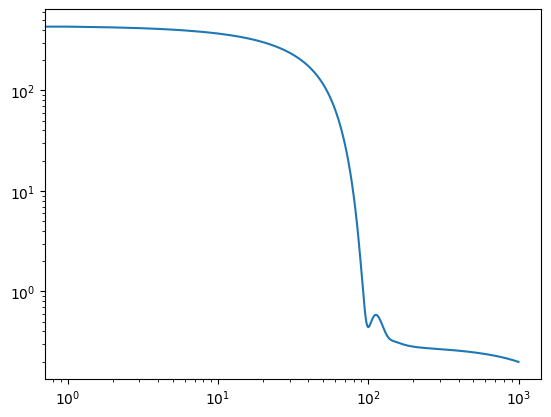

In [187]:
# plt.plot(losses)
plt.loglog(losses)

In [189]:
pred_usual = model_()
# pred_usual = move_orbitals_to_keys(pred_usual, target_coupled_blocks_copy[0].properties)
print(L2_loss(pred_usual, target_coupled_blocks_copy))

tensor(0.1991, grad_fn=<AddBackward0>)


### Batching

In [58]:
split_by_axis = "samples"
split_by_dimension = "structure"

split_by_axis = "samples"
split_by_dimension = "structure"

grouped_labels = [mts.Labels(names = split_by_dimension, values = torch.tensor([A])) for A in mts.unique_metadata(target_coupled_blocks,
                                                                                                                  axis = split_by_axis,
                                                                                                                  names = split_by_dimension)]
split_target = mts.split(target_coupled_blocks, split_by_axis, grouped_labels)

grouped_labels = [mts.Labels(names = split_by_dimension, values = torch.tensor([A])) for A in mts.unique_metadata(overlap_coupled_blocks,
                                                                                                                  axis = split_by_axis,
                                                                                                                  names = split_by_dimension)]
#split_overlaps = mts.split(overlap_coupled_blocks, split_by_axis, grouped_labels)

grouped_labels = [mts.Labels(names = split_by_dimension, values = torch.tensor([A])) for A in mts.unique_metadata(hfeat, axis = split_by_axis,
                                                                                                                  names = split_by_dimension)]
split_features = mts.split(hfeat, split_by_axis, grouped_labels)

ml_data = IndexedDataset(descriptor = split_features,
                         target = split_target,
                         target_k = target_kspace,
                         sample_id = [g.values.tolist()[0][0] for g in grouped_labels])

batch_size = 1

from metatensor.learn import DataLoader
dataloader = DataLoader(ml_data,
                        batch_size = batch_size,
                        shuffle = True,
                        collate_fn = lambda x: group_and_join_mts(x, join_kwargs = {'different_keys': 'union', 'remove_tensor_name': True}))


# Splitting dataset random seed on jed 

In [ ]:
f=[]
for i in range(7):
    f.append(mts.load(f'features_{i*20}_{(i+1)*20}'))
f.append(mts.load('../test/features_140_172'))
np.random.seed(73)
indices = np.arange(172)
np.random.shuffle(indices)
np.savetxt('random_indices.txt', indices, header = 'seed = 73', fmt = '%d')
batched = {}
for i in range(0,7):
    selid = indices[i*20:20*(i+1)]
    batched[i]=[]
    for iid in selid:
        # batched[i].append(iid)
        batched[i].append(split_features[iid])
batched[8]=[]
selid = indices[140:]
for iid in selid:
    # batched[i].append(iid)
    batched[i].append(split_features[iid])


for i in batched.keys(): 
    features = mts.join(batched[i], axis='samples')
    blocks = []
    for k, b in features.items():
            sample_values = b.samples.values
            sample_values[:, 0] = sample_values[:, 6]
            samples = mts.Labels(b.samples.names[:-1], sample_values[:, :-1])
            blocks.append(mts.TensorBlock(
            values = b.values,
            samples = samples,
            properties = b.properties,
            components = b.components
            ))
    features = mts.TensorMap(features.keys, blocks)
    features.save(f'features_{i*20}_{(i+1)*20}_seed73')

# Equivariance

In [16]:
from mlelec.utils.symmetry import _wigner_d_real
from mlelec.models.linear import E3LayerNorm

In [17]:
workdir = '.'
root = f'{workdir}/examples/data/periodic'
ORBS = 'sto-3g'
frames = read(f'{root}/c2/rotated/C2_rotated.xyz', ':')

kmesh = [15,15,1]
rfock = [np.load(f"{root}/c2/rotated/{i}/realfock_{i}.npy", allow_pickle = True).item() for i in range(len(frames))]
rover = [np.load(f"{root}/c2/rotated/{i}/realoverlap_{i}.npy", allow_pickle = True).item() for i in range(len(frames))]

rotations = np.load(f"{root}/c2/rotated/rotations.npy")

dataset = QMDataset(frames = frames, 
                   kmesh = kmesh, 
                   dimension = 2,
                   fock_realspace = rfock, 
                   overlap_realspace = rover, 
                   device = device, 
                   orbs = orbitals[ORBS], 
                   orbs_name = 'sto-3g')

In [18]:
cutoff = 8
_, target_coupled_blocks = get_targets(dataset, cutoff = cutoff, device = device)

In [19]:
atol = 1e-8
rtol = 1e-7
for k,b in target_coupled_blocks.items():
    L = k['L']
    b0 = mts.slice_block(b, axis='samples', labels=Labels(["structure"], torch.tensor([0]).reshape(1,1)))

    for i, rot in enumerate(rotations):
        b1 = mts.slice_block(b, axis='samples', labels=Labels(["structure"], torch.tensor([i+1]).reshape(1,1)))
        wd = _wigner_d_real(L, *rot)    
        assert torch.allclose(b1.values, torch.einsum('ab,sbp->sap', wd, b0.values), atol=atol, rtol = rtol), (f"Rotation equivariance test failed for key {k.values.tolist()}", 
                                                                                                             torch.norm(b1.values-torch.einsum('ab,sbp->sap', wd, b0.values)), 
                                                                                                             atol + rtol*torch.norm(torch.einsum('ab,sbp->sap', wd, b0.values))
                                                                                                            )
        # print(i+1, k.values.tolist(), torch.norm(b1.values-torch.einsum('ab,sbp->sap', wd, b0.values)))

In [20]:
import rascaline
max_radial  = 8
max_angular = 6
atomic_gaussian_width = 0.3
cutoff = 8
hypers_pair = {'cutoff': cutoff,
               'max_radial': max_radial,
               'max_angular': max_angular,
               'atomic_gaussian_width': atomic_gaussian_width,
               'center_atom_weight': 1,
               "radial_basis": {"Gto": {}},
               "cutoff_function": {"ShiftedCosine": {"width": 0.1}}}


hypers_atom = {'cutoff': 4,
               'max_radial': max_radial,
               'max_angular': max_angular,
               'atomic_gaussian_width': 0.3,
               'center_atom_weight': 1,
               "radial_basis": {"Gto": {}},
               "cutoff_function": {"ShiftedCosine": {"width": 0.1}}}


return_rho0ij = False
both_centers = False
all_pairs = False
LCUT = 3

from mlelec.features.acdc import compute_features
features = compute_features(dataset, hypers_atom, 3, hypers_pair = hypers_pair)

cpu pair features
cpu single center features
cpu single center features


In [21]:
atol = 1e-8
rtol = 1e-7
for k,b in features.items():
    L = k['spherical_harmonics_l']
    b0 = mts.slice_block(b, axis='samples', labels=Labels(["structure"], torch.tensor([0]).reshape(1,1)))

    for i, rot in enumerate(rotations):
        b1 = mts.slice_block(b, axis='samples', labels=Labels(["structure"], torch.tensor([i+1]).reshape(1,1)))
        wd = _wigner_d_real(L, *rot)    
        assert torch.allclose(b1.values, torch.einsum('ab,sbp->sap', wd, b0.values), atol=atol, rtol = rtol), (f"Rotation equivariance test failed for key {k.values.tolist()}", 
                                                                                                             torch.norm(b1.values-torch.einsum('ab,sbp->sap', wd, b0.values)), 
                                                                                                             atol + rtol*torch.norm(torch.einsum('ab,sbp->sap', wd, b0.values))
                                                                                                            )
        # print(i+1, k.values.tolist(), torch.norm(b1.values-torch.einsum('ab,sbp->sap', wd, b0.values)))

In [22]:
keyidx = 2
b = features[keyidx]
t = b.values*3
k = features.keys[keyidx]
L = k['spherical_harmonics_l']
tensor = b.values
# print(tensor.shape)
e3lnorm = E3LayerNorm(layersize=b.values.shape[-1],bias = True)
optim = torch.optim.Adam(e3lnorm.parameters(), lr = 1e-3)

In [23]:
list(e3lnorm.parameters())

[Parameter containing:
 tensor([-0.1672], requires_grad=True),
 Parameter containing:
 tensor([0.2538], requires_grad=True)]

In [24]:
list(e3lnorm.parameters())


[Parameter containing:
 tensor([-0.1672], requires_grad=True),
 Parameter containing:
 tensor([0.2538], requires_grad=True)]

In [26]:
for epoch in range(1000):
    optim.zero_grad()
    e3 = e3lnorm(tensor)
    # print(e3.shape)
    loss = torch.norm(e3 - t)**2
    loss.backward()
    optim.step()
    print(epoch, loss.item())

0 108.82554082348027
1 105.17718742664975
2 101.59428664638045
3 98.07792157263597
4 94.62911370126896
5 91.24881845686178
6 87.93792097139398
7 84.69723215177513
8 81.5274850669072
9 78.42933168031148
10 75.40333995212282
11 72.44999132882403
12 69.56967863604463
13 66.76270438513002
14 64.02927950005243
15 61.36952246710201
16 58.78345890604381
17 56.27102155757282
18 53.83205067839165
19 51.46629483209699
20 49.17341206133426
21 46.952971423930215
22 44.80445487372298
23 42.72725946518825
24 40.720699859109494
25 38.78401110592977
26 36.91635168226691
27 35.11680675607518
28 33.38439165509417
29 31.718055514049492
30 30.116685075791846
31 28.57910862218892
32 27.1041000113542
33 25.690382798321636
34 24.336634417223593
35 23.041490404027112
36 21.803548639655716
37 20.621373594615925
38 19.493500556939985
39 18.418439826742258
40 17.394680861204236
41 16.420696355329714
42 15.494946244470652
43 14.615881615752315
44 13.78194851662334
45 12.99159164932783
46 12.243257941558092
47 11.

In [27]:
e3 = e3lnorm(tensor)
e3b = TensorBlock(values = e3, samples = b.samples, components = b.components, properties = b.properties)
    
b0 = mts.slice_block(e3b, axis='samples', labels=Labels(["structure"], torch.tensor([0]).reshape(1,1)))
for i, rot in enumerate(rotations):
    b1 = mts.slice_block(e3b, axis='samples', labels=Labels(["structure"], torch.tensor([i+1]).reshape(1,1)))
    wd = _wigner_d_real(L, *rot)    
    assert torch.allclose(b1.values, torch.einsum('ab,sbp->sap', wd, b0.values), atol=atol, rtol = rtol), (f"Rotation equivariance test failed for key {k.values.tolist()}", 
                                                                                                         torch.norm(b1.values-torch.einsum('ab,sbp->sap', wd, b0.values)), 
                                                                                                         atol + rtol*torch.norm(torch.einsum('ab,sbp->sap', wd, b0.values))
                                                                                                        )
    print(i+1, k.values.tolist(), torch.norm(b1.values-torch.einsum('ab,sbp->sap', wd, b0.values)))


1 [2, 1, 2, 6, 6, 0] tensor(5.5213e-08, grad_fn=<LinalgVectorNormBackward0>)
2 [2, 1, 2, 6, 6, 0] tensor(1.1705e-07, grad_fn=<LinalgVectorNormBackward0>)


In [30]:
aa = torch.randn(6,3,4)
c = torch.randn(4)
bb = aa+ c.view(1,1,4)

In [34]:
c

tensor([ 0.4127, -0.3959, -0.5555,  0.0543])

In [31]:
bb[0]

tensor([[ 1.3740,  0.1740, -0.4808, -0.8062],
        [ 0.5752,  0.3189, -2.2159, -0.9918],
        [-0.3546,  0.2316, -0.9255,  0.0672]])

In [33]:
aa[0]

tensor([[ 0.9613,  0.5699,  0.0747, -0.8605],
        [ 0.1625,  0.7148, -1.6604, -1.0461],
        [-0.7673,  0.6275, -0.3700,  0.0129]])

In [28]:
for keyidx  in range(len(features)):
    k = features.keys[keyidx]
    b = features[keyidx]
    L = k['spherical_harmonics_l']
    tensor = b.values
    mean = tensor.mean(dim = (2), keepdim = True)
    std = torch.sqrt(tensor.var(keepdim = True) + 1e-6)
    e3 = (tensor-mean) #/ std
    e3[...,0] 
    # dummy = target_coupled_blocks[0].properties
    # e3b = TensorBlock(values = mean, samples = b.samples, components = b.components, properties = dummy)
    e3b = TensorBlock(values = e3, samples = b.samples, components = b.components, properties = b.properties)
    
    b0 = mts.slice_block(e3b, axis='samples', labels=Labels(["structure"], torch.tensor([0]).reshape(1,1)))
    # print(b0.values.shape)
    for i, rot in enumerate(rotations):
        b1 = mts.slice_block(e3b, axis='samples', labels=Labels(["structure"], torch.tensor([i+1]).reshape(1,1)))
        wd = _wigner_d_real(L, *rot)    
        assert torch.allclose(b1.values, torch.einsum('ab,sbp->sap', wd, b0.values), atol=atol, rtol = rtol), (f"Rotation equivariance test failed for key {k.values.tolist()}", 
                                                                                                             torch.norm(b1.values-torch.einsum('ab,sbp->sap', wd, b0.values)), 
                                                                                                             atol + rtol*torch.norm(torch.einsum('ab,sbp->sap', wd, b0.values))
                                                                                                            )
        print(i+1, k.values.tolist(), torch.norm(b1.values-torch.einsum('ab,sbp->sap', wd, b0.values)))

1 [2, 1, 0, 6, 6, 0] tensor(1.2281e-09)
2 [2, 1, 0, 6, 6, 0] tensor(5.2012e-10)
1 [2, 1, 1, 6, 6, 0] tensor(1.4986e-08)
2 [2, 1, 1, 6, 6, 0] tensor(3.2348e-08)
1 [2, 1, 2, 6, 6, 0] tensor(1.8393e-08)
2 [2, 1, 2, 6, 6, 0] tensor(3.8989e-08)
1 [2, 1, 3, 6, 6, 0] tensor(1.8336e-08)
2 [2, 1, 3, 6, 6, 0] tensor(3.9044e-08)
1 [2, -1, 1, 6, 6, 0] tensor(1.1135e-09)
2 [2, -1, 1, 6, 6, 0] tensor(3.8124e-09)
1 [2, -1, 2, 6, 6, 0] tensor(9.5609e-09)
2 [2, -1, 2, 6, 6, 0] tensor(2.0311e-08)
1 [2, -1, 3, 6, 6, 0] tensor(1.6685e-08)
2 [2, -1, 3, 6, 6, 0] tensor(3.4824e-08)
1 [2, 1, 0, 6, 6, 1] tensor(7.5982e-09)
2 [2, 1, 0, 6, 6, 1] tensor(1.5484e-08)
1 [2, 1, 0, 6, 6, -1] tensor(2.8189e-09)
2 [2, 1, 0, 6, 6, -1] tensor(6.1056e-09)
1 [2, 1, 1, 6, 6, 1] tensor(7.2096e-09)
2 [2, 1, 1, 6, 6, 1] tensor(1.5153e-08)
1 [2, 1, 1, 6, 6, -1] tensor(1.6874e-08)
2 [2, 1, 1, 6, 6, -1] tensor(3.4756e-08)
1 [2, 1, 2, 6, 6, 1] tensor(2.4655e-08)
2 [2, 1, 2, 6, 6, 1] tensor(5.0651e-08)
1 [2, 1, 2, 6, 6, -1] tensor(9

In [54]:
 e3[...,0]*2

tensor([[ 0.0000e+00,  7.0122e-05,  0.0000e+00,  ...,  0.0000e+00,
         -1.2700e-04,  0.0000e+00],
        [ 0.0000e+00, -8.0773e-05,  0.0000e+00,  ...,  0.0000e+00,
          6.7626e-05,  0.0000e+00],
        [ 0.0000e+00, -5.3004e-05,  0.0000e+00,  ...,  0.0000e+00,
         -2.1004e-04,  0.0000e+00],
        ...,
        [-1.0589e-04,  2.3576e-05, -1.3280e-04,  ...,  1.1408e-04,
         -6.5246e-05,  5.2856e-05],
        [ 8.0307e-05,  6.2730e-05, -7.4024e-05,  ..., -8.9345e-06,
         -1.1389e-04,  8.7713e-05],
        [-8.1998e-05, -1.2061e-05, -3.8075e-05,  ...,  1.9186e-05,
          1.7077e-05, -4.8380e-05]])

In [47]:
mean

tensor([[[ 0.0137],
         [ 0.0211],
         [-0.0157],
         [ 0.0027],
         [ 0.0134]]])

In [42]:
std

tensor([[[0.0069]]])

# Tests on SPH scipy

In [8]:
from scipy.special import sph_harm
from scipy.spatial.transform import * 
import numpy as np 
import torch
def hermitian_adj(x):
    return np.conjugate(x.T)

def cart2sph(xyz):
    x,y,z = xyz[0], xyz[1], xyz[2]
    x2y2 = x**2 + y**2
    r = np.sqrt(x2y2 + z**2)               # r
    theta = np.arccos(z/r)     # theta
    # theta = np.arctan2(x2y2,z)     # theta
    # if z==0 and x*y!=0:
    #     theta=np.pi/2
        
    phi = np.arctan2(y,x)                           # phi
    return r, theta, phi

def rotz(phi):
    rotz = np.zeros((3,3)) 
    rotz[2][2] =1
    rotz[0,0] = np.cos(phi)
    rotz[1,1] = np.cos(phi)
    rotz[0,1] = -np.sin(phi)
    rotz[1,0] = np.sin(phi)
    return rotz

def roty(phi):
    roty = np.zeros((3,3)) 
    roty[1,1] = 1
    roty[0,0] = np.cos(phi)
    roty[0,2] = np.sin(phi)
    
    roty[2,0] = -np.sin(phi)
    roty[2,2] = np.cos(phi)
    return roty

In [9]:
L = 3
alpha = -1
theta,phi = np.random.uniform(0,np.pi),np.random.uniform(0,2*np.pi)
Ylm = torch.tensor([sph_harm(m, L, phi,theta) for m in range(-L,L+1)])
xyz = [np.sin(theta)*np.cos(phi),np.sin(theta)*np.sin(phi), np.cos(theta) ]

theta,phi = np.random.uniform(0,np.pi),np.random.uniform(0,2*np.pi)
Ylm1 = torch.tensor([sph_harm(m, L, phi,theta) for m in range(-L,L+1)])
xyz1 = [np.sin(theta)*np.cos(phi),np.sin(theta)*np.sin(phi), np.cos(theta) ]

In [10]:
# Ylm = Ylm+Ylm1
Ylm = Ylm+alpha*Ylm1

In [11]:
rotation_angles =[np.random.uniform(0, 2*np.pi), np.random.uniform(-np.pi/2, np.pi/2), np.random.uniform(0, 2*np.pi)]

In [12]:
# rot_xyz = Rotation.from_euler('zyz', rotation_angles).as_matrix() @xyz
# rot_xyz1 = Rotation.from_euler('zyz', rotation_angles).as_matrix() @xyz1

In [13]:
r, rot_theta, rot_phi = cart2sph(rotz(rotation_angles[0])@roty(rotation_angles[1])@(rotz(rotation_angles[2])@xyz))
Ylm_rot = np.asarray([sph_harm(m, L, rot_phi,rot_theta) for m in range(-L,L+1)])
print(np.asarray(Ylm_rot))

[ 0.26391891+0.30559036j -0.1235342 -0.07958168j -0.27355577-0.08048577j
  0.15860537+0.j          0.27355577-0.08048577j -0.1235342 +0.07958168j
 -0.26391891+0.30559036j]


In [14]:
r, rot_theta, rot_phi = cart2sph(rotz(rotation_angles[0])@roty(rotation_angles[1])@(rotz(rotation_angles[2])@xyz1))
Ylm_rot1 = np.asarray([sph_harm(m, L, rot_phi,rot_theta) for m in range(-L,L+1)])

In [15]:
# Ylm_rot+= Ylm_rot1
Ylm_rot+= alpha*Ylm_rot1

In [16]:
from mlelec.utils.symmetry import _wigner_d
wd = _wigner_d(L, *rotation_angles)#.numpy()

In [17]:
rotate_sph = torch.einsum("q, qm->m", Ylm, hermitian_adj(wd))
# rotate_sph += torch.einsum("q, qm->m", Ylm1, hermitian_adj(wd))
rotate_sph += alpha*torch.einsum("q, qm->m", Ylm1, hermitian_adj(wd))
# print(r'diff between $\mathbf{R}Y(\hat{r}) and Y(\mathbf{R}\hat{r})', torch.norm(rotate_sph - Ylm_rot).item())

In [18]:
rotate_sph = torch.einsum("q, qm->m", Ylm, hermitian_adj(wd))
print(r'diff between $\mathbf{R}Y(\hat{r}) and Y(\mathbf{R}\hat{r})', torch.norm(rotate_sph - Ylm_rot).item())

diff between $\mathbf{R}Y(\hat{r}) and Y(\mathbf{R}\hat{r}) 3.849053922355312e-16


In [19]:
# theta1,ph1i = np.random.uniform(size=(2))*np.pi


# stupidly simple test on initializing an nn parameter

In [87]:
import torch.nn as nn 
class E3Lnorm(nn.Module):
    def __init__(self):
        super().__init__()
        self.alpha = nn.Parameter(data=torch.randn(1), requires_grad=True)
    def forward(self):
        return self.alpha+3

e3 = E3Lnorm()
e3.forward()
optim = torch.optim.Adam(e3.parameters(), lr = 1e-2)
for epoch in range(500):
    optim.zero_grad()
    loss = torch.norm(e3()-1)**2
    loss.backward()
    # if loss.item()<1e-4:
    #     break
    optim.step()
    print(epoch, loss)

0 tensor(3.7933, grad_fn=<PowBackward0>)
1 tensor(3.7544, grad_fn=<PowBackward0>)
2 tensor(3.7158, grad_fn=<PowBackward0>)
3 tensor(3.6773, grad_fn=<PowBackward0>)
4 tensor(3.6391, grad_fn=<PowBackward0>)
5 tensor(3.6011, grad_fn=<PowBackward0>)
6 tensor(3.5633, grad_fn=<PowBackward0>)
7 tensor(3.5257, grad_fn=<PowBackward0>)
8 tensor(3.4884, grad_fn=<PowBackward0>)
9 tensor(3.4513, grad_fn=<PowBackward0>)
10 tensor(3.4144, grad_fn=<PowBackward0>)
11 tensor(3.3777, grad_fn=<PowBackward0>)
12 tensor(3.3413, grad_fn=<PowBackward0>)
13 tensor(3.3051, grad_fn=<PowBackward0>)
14 tensor(3.2692, grad_fn=<PowBackward0>)
15 tensor(3.2335, grad_fn=<PowBackward0>)
16 tensor(3.1980, grad_fn=<PowBackward0>)
17 tensor(3.1628, grad_fn=<PowBackward0>)
18 tensor(3.1279, grad_fn=<PowBackward0>)
19 tensor(3.0932, grad_fn=<PowBackward0>)
20 tensor(3.0587, grad_fn=<PowBackward0>)
21 tensor(3.0245, grad_fn=<PowBackward0>)
22 tensor(2.9906, grad_fn=<PowBackward0>)
23 tensor(2.9569, grad_fn=<PowBackward0>)
24

In [88]:

e3.alpha

Parameter containing:
tensor([-2.0000], requires_grad=True)